[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/12_monsters_and_mixtures.ipynb)

# Chapter 12 - Monsters and Mixtures


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz
    !pip install tensorflow_probability==0.9.0

In [2]:
%load_ext watermark

In [3]:
from functools import partial

# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats
from scipy.interpolate import griddata
from scipy.interpolate import BSpline

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 0.25.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

### Tensorflow MCMC sampling helpers

In [6]:
# Helper functions to run MCMC Sampling
def trace_to_arviz(trace, sample_stats=None):
    posterior = {k: np.expand_dims(v, axis=0) for k, v in trace.items()}
    if sample_stats:
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    return az.from_dict(posterior=posterior, sample_stats=sample_stats)

@tf.function
def run_hmc_chain(log_posterior, inits=dict(), step_size=1, burn_in=2000, num_samples=5000):
    
  adaptation_steps = int(0.5 * burn_in)
  
  hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      # The actual HMC is very simple to define
      tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn = log_posterior,    # Log Posterior goes here
          num_leapfrog_steps = 3,
          step_size = step_size                  # constant step size
      ),
      num_adaptation_steps = adaptation_steps
  )
    
  results = tfp.mcmc.sample_chain(
      num_results = num_samples,
      num_burnin_steps = burn_in,
      current_state = inits.values(),
      kernel = hmc,
      trace_fn=None
  )
  return results

def sample_mcmc_hmc(log_posterior, inits=dict(), step_size=0.1, burn_in=1000, num_samples=1000):
    results = run_hmc_chain(log_posterior, inits, step_size, burn_in, num_samples)
    numpy_results = list(map(lambda r : r.numpy(), results))
    posterior = dict(zip(list(inits.keys()), numpy_results))    
    return posterior

def sample_from_posterior(jdc, observed_data, params, step_size=0.1):    
    """ Helper function to sample from the posterior distribution given the observed value"""
    
    # we get the sample from our model definition
    # that will act as the init state for the chain
    samples = jdc.sample()    
    samples_without_outcome = samples[:-1]
    
    # build a dicitonary using the params
    init_state = dict(zip(params, samples_without_outcome))

    target_log_prob_fn = lambda *x: jdc.log_prob(x + (observed_data,))

    return sample_mcmc_hmc(target_log_prob_fn,inits=init_state,step_size=step_size)
    
def squeeze_post(post):
    return {k : v.squeeze() for k, v in post.items()}

### Dataset URLs


In [7]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"

UCBADMIT_DATASET_PATH = f"{_BASE_URL}/UCBadmit.csv"

## Code 12.1


A beta distribution is a probability distribution for probabilities !

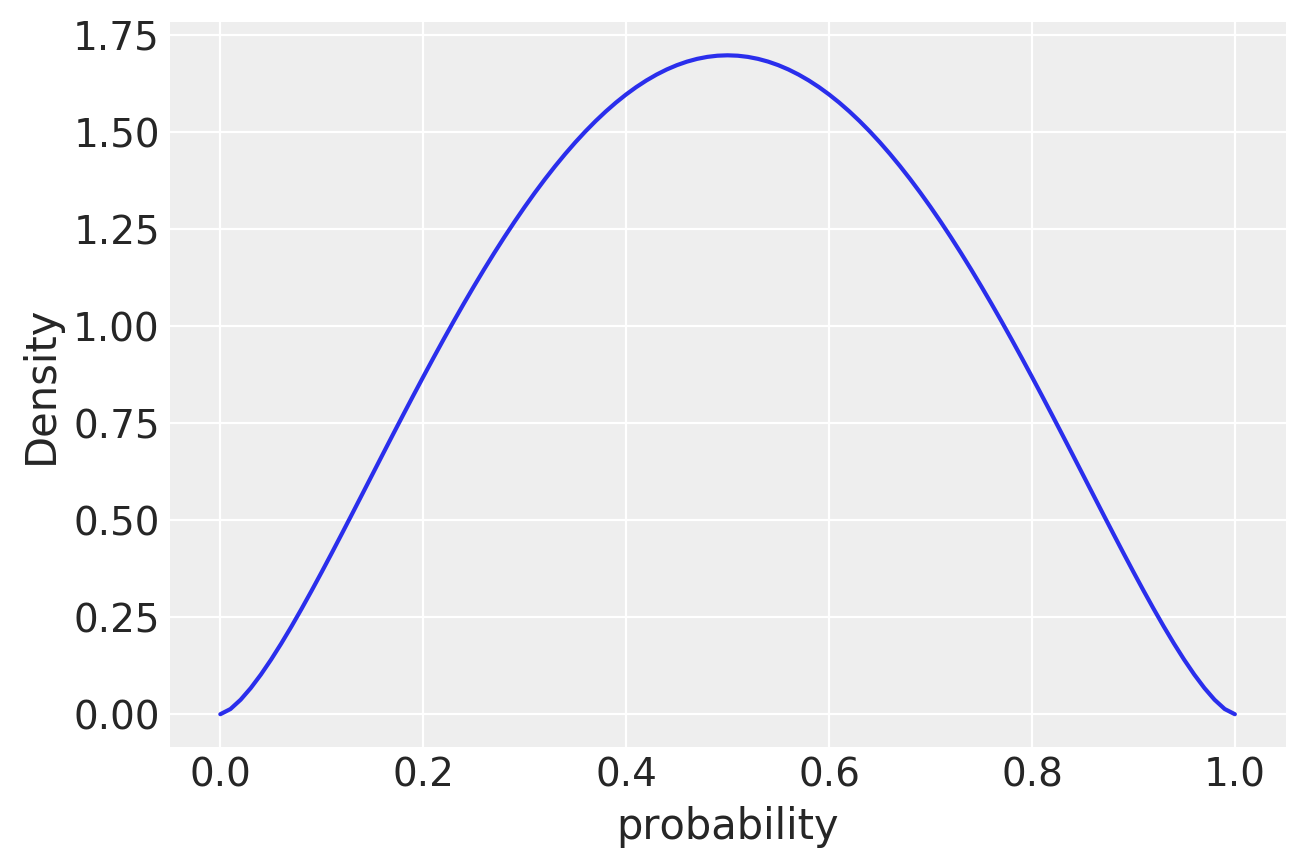

In [8]:
pbar = 0.5   # mean
theta = 5    # total concentration

alpha = pbar * theta
beta = (1 - pbar) * theta

x = np.linspace(0, 1, 101)

plt.plot(x, tf.exp(tfd.Beta(alpha, beta).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density");

## Code 12.2

In [9]:
d = pd.read_csv(UCBADMIT_DATASET_PATH, sep=";")
d["gid"] = (d["applicant.gender"] != "male").astype(int)

In [10]:
def model_12_1(gid, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=2))
      phi = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      theta = phi + 2
      pbar = tf.sigmoid(tf.squeeze(tf.gather(alpha, gid, axis=-1)))        
        
      # prepare the concentration vector
      concentration1 = pbar * theta
      concentration0 = (1 - pbar) * theta    
    
      concentration = tf.stack([concentration1, concentration0], axis=-1)
        
      # outcome A i.e. admit  
      # since it is a multinomial we will have K = 2
      # so this does not really behave like Binomial in terms of the sample shape
      A = yield tfd.Independent(tfd.DirichletMultinomial(total_count=N, concentration=concentration), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_12_1 = model_12_1(d.gid.values, tf.cast(d.applications.values, dtype=tf.float32))

## Code 12.3

In [11]:
# Prepare the expected shape by the DirichletMultinomial  
admit_values = tf.constant(d.admit.values, dtype=tf.float32)
reject_values = tf.constant(d.reject.values, dtype=tf.float32)
obs_values = tf.stack([admit_values, reject_values], axis=-1)

posterior_12_1 = sample_from_posterior(jdc_12_1, observed_data=obs_values, params=['alpha', 'phi'])

# compute the difference between alphas
posterior_12_1["da"] = posterior_12_1["alpha"][:, 0] - \
        posterior_12_1["alpha"][:, 1]

# compute theta
posterior_12_1["theta"] = posterior_12_1["phi"][:, 0] + 2

az.summary(trace_to_arviz(posterior_12_1), round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha[0],-0.45,0.45,-1.27,0.43
alpha[1],-0.29,0.46,-1.12,0.59
phi[0],0.68,0.95,-1.02,2.37
da,-0.16,0.67,-1.46,1.12
theta,2.68,0.95,0.98,4.37


## Code 12.4

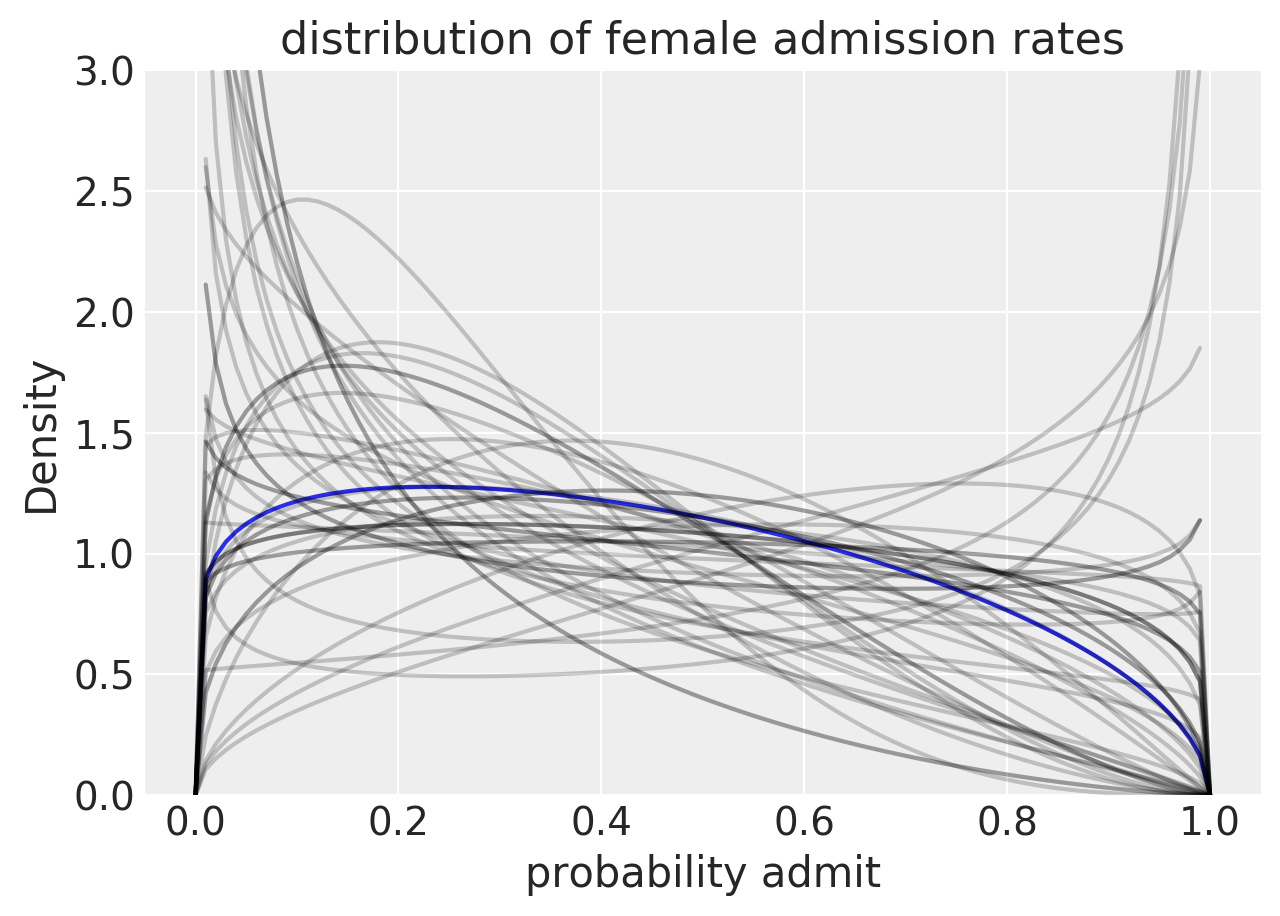

In [12]:
from scipy.special import expit

gid = 1
# draw posterior mean beta distribution
x = np.linspace(0, 1, 101)
pbar = tf.reduce_mean(tf.sigmoid(posterior_12_1["alpha"][:, gid]))
theta = tf.reduce_mean(posterior_12_1["theta"])
plt.plot(x, tf.exp(tfd.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3));

# draw 50 beta distributions sampled from posterior
for i in range(50):
    p = tf.sigmoid(posterior_12_1["alpha"][i, gid])
    theta = posterior_12_1["theta"][i]
    plt.plot(x, tf.exp(tfd.Beta(p * theta, (1 - p) * theta).log_prob(x)),
             "k", alpha=0.2)
plt.title("distribution of female admission rates");

## Code 12.5

In [13]:
# get samples given the posterior distribution
N = tf.cast(d.applications.values, dtype=tf.float32)
gid = d.gid.values

sample_alpha = posterior_12_1["alpha"]
sample_theta = posterior_12_1["theta"]

sample_pbar = tf.sigmoid(tf.squeeze(tf.gather(sample_alpha, gid, axis=-1)))    

# need to reshape it to make it happy
st = tf.reshape(sample_theta, shape=(1000,1))

# prepare the concentration vector
concentration1 = sample_pbar * st
concentration0 = (1 - sample_pbar) * st    

concentration = tf.stack([concentration1, concentration0], axis=-1)

dist = tfd.DirichletMultinomial(total_count=N, concentration=concentration)

predictive_samples = dist.sample()

In [14]:
# numpy style indexing magic ! .. hate it !
admit_rate = predictive_samples[::,::,0] / N

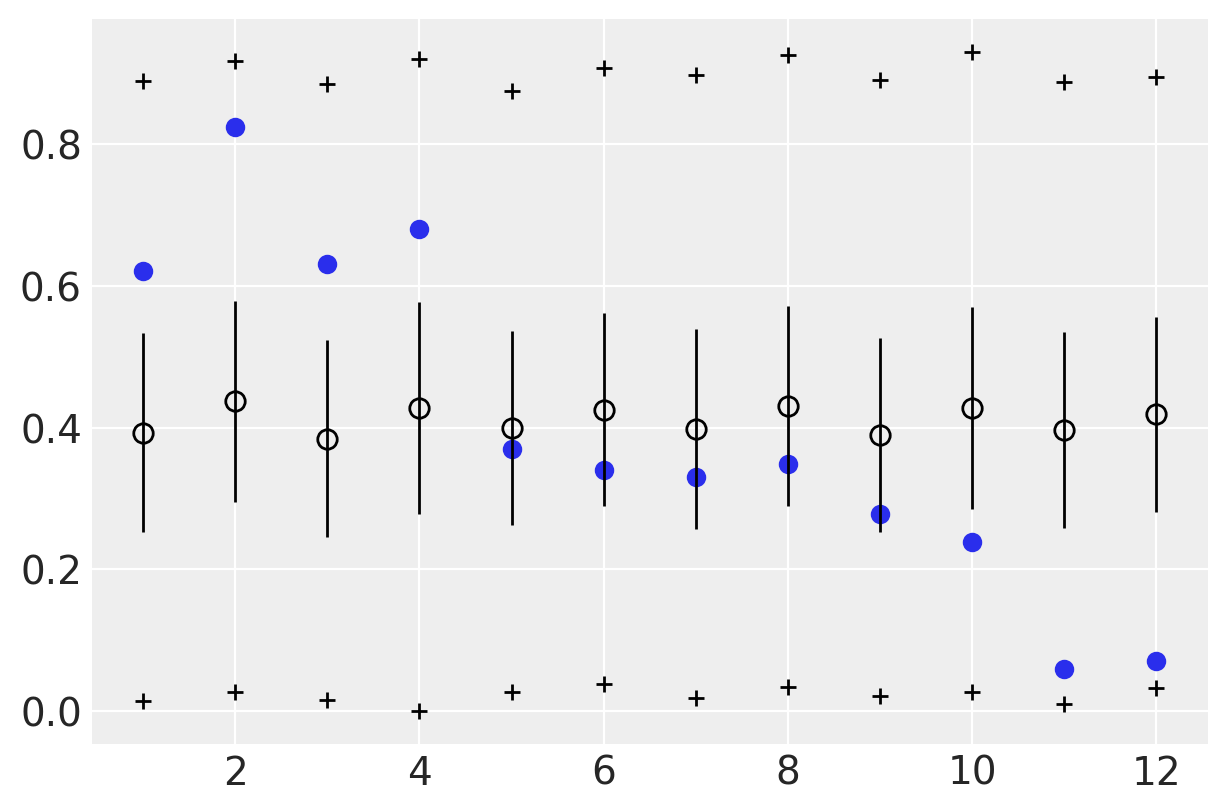

In [15]:
plt.scatter(range(1, 13), d.admit.values /N)
plt.errorbar(range(1, 13), np.mean(admit_rate, 0), np.std(admit_rate, 0) / 2,
             fmt="o", c="k", mfc="none", ms=7, elinewidth=1)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+");

In the above plot, the vertifical axis shows the predicted proportion admitted, for each case on the horizontal.

Blue points show the empirical proportion admitted on each row of data

Open circles are the posterior mean pbar and + symbols mark the 89% interval of predicted counts of admission